In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Parameters
num_pevgs = 5  # Number of PEVGs
grid_capacity = 99  # Total energy available from the grid (MWh)
max_iterations = 100  # Maximum number of iterations
population_size = 100  # Number of particles
local_search_iterations = 10  # Number of local search iterations
delta = 0.5  # Local search parameter

In [3]:

# Bounds
price_lower_bound = 20  # Lower bound for price (USD/MWh)
price_upper_bound = 60  # Upper bound for price (USD/MWh)
battery_capacity_lower_bound = 35  # Lower bound for battery capacity (MWh)
battery_capacity_upper_bound = 65  # Upper bound for battery capacity (MWh)


# PEVG parameters

In [4]:
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)  # Battery capacities (MWh)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)  # Satisfaction parameters


# Initialize population

In [5]:

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)  # Initial price (USD/MWh)
        population.append((energy_demands, price))
    return population

# Objectives

In [6]:

# Utility function for PEVGs
def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return utilities

In [7]:
# Revenue function for the grid
def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

In [8]:
# Constraint handling: Ensure total energy demand <= grid capacity
def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return energy_demands

# Local search

In [9]:

def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        if np.sum(new_energy_demands) <= grid_capacity:
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

In [10]:
# Check if one solution dominates another
def dominates(solution1, solution2):
    # solution1 dominates solution2 if it is better in at least one objective and not worse in any other
    better_in_one = False
    for i in range(len(solution1)):
        if solution1[i] < solution2[i]:
            return False
        if solution1[i] > solution2[i]:
            better_in_one = True
    return better_in_one

# Update Pareto front

In [11]:

def update_pareto_front(pareto_front, new_solution):
    # Add new_solution to the Pareto front if it is not dominated by any existing solution
    to_remove = []
    for i, solution in enumerate(pareto_front):
        if dominates(solution, new_solution):
            return pareto_front  # new_solution is dominated, do not add it
        if dominates(new_solution, solution):
            to_remove.append(i)  # existing solution is dominated by new_solution
    # Remove dominated solutions
    pareto_front = [solution for j, solution in enumerate(pareto_front) if j not in to_remove]
    # Add new_solution to the Pareto front
    pareto_front.append(new_solution)
    return pareto_front

In [12]:
# def update_pareto_front(pareto_front, new_solutions):
#     res = []
#     for i in range(len(pareto_front)):
#         if dominates(pareto_front[i], new_solutions[i]):
#             res.append(pareto_front[i])
#         elif dominates( new_solutions[i] , pareto_front[i]):
#             res.append(new_solutions[i])
#     return res

In [13]:
def find_1(particles):
    best = particles[0][0]
    for i in range( 0 ,len(particles) ):
        if best < particles[i][0]:
            best = particles[i][0]
    obj1.append(best)

In [14]:
def find_2(particles):
    best = particles[0][1]
    for i in range( 0 ,len(particles) ):
        if best < particles[i][1]:
            best = particles[i][1]
    obj2.append(best)

In [15]:
def general_distance(pareto_front_history):
    distances = []
    for i in range(len(pareto_front_history)):
        if i == 0:
            distances.append(0)
            continue
        prev_front = np.array(pareto_front_history[i - 1])
        current_front = np.array(pareto_front_history[i])
        
        if len(prev_front) == 0 or len(current_front) == 0:
            distances.append(0)
            continue
        
        distance = np.mean([np.min(np.linalg.norm(current_front - p, axis=1)) for p in prev_front])
        distances.append(distance)
    
    return distances

In [16]:
# Improve Diversity: Add crowding distance sorting
def crowding_distance_sort(pareto_front):
    if len(pareto_front) == 0:
        return []
    pareto_front = np.array(pareto_front)
    num_points = pareto_front.shape[0]
    num_objectives = pareto_front.shape[1]
    distances = np.zeros(num_points)
    
    for m in range(num_objectives):
        sorted_indices = np.argsort(pareto_front[:, m])
        distances[sorted_indices[0]] = np.inf
        distances[sorted_indices[-1]] = np.inf
        
        for i in range(1, num_points - 1):
            distances[sorted_indices[i]] += (pareto_front[sorted_indices[i + 1], m] - pareto_front[sorted_indices[i - 1], m])
    
    sorted_indices = np.argsort(-distances)  # Sort in descending order of crowding distance
    return pareto_front[sorted_indices].tolist()

# EMA algorithm

In [17]:

# def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
#     population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
#     pareto_front = []  # Initialize Pareto front
    
#     for iteration in range(max_iterations):
#         # Evaluate fitness
#         fitness = []
#         for particle in population:
#             energy_demands, price = particle
#             utilities = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
#             revenue = revenue_function(energy_demands, price)
#             fitness.append((np.sum(utilities), revenue))

#         # if(len(pareto_front) == 0): 
#         #     pareto_front = fitness
#         # else: 
#         #     pareto_front = update_pareto_front(pareto_front, fitness)
        
#         # Update Pareto front
#         for i in range(population_size):
#             pareto_front = update_pareto_front(pareto_front, fitness[i])

#         # find_1(pareto_front)
#         # find_2(pareto_front)
        
#         # Calculate forces
#         forces = []
#         for i in range(population_size):
#             force = np.zeros(num_pevgs + 1)
#             for j in range(population_size):
#                 if i != j:
#                     diff = np.array(list(population[j][0]) + [population[j][1]]) - np.array(list(population[i][0]) + [population[i][1]])
#                     force += diff / np.linalg.norm(diff)**2
#             forces.append(force)
        
#         # Move particles
#         for i in range(population_size):
#             energy_demands, price = population[i]
#             force = forces[i]
#             new_energy_demands = energy_demands + delta * force[:-1]
#             new_price = price + delta * force[-1]
#             new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
#             new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
#             new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
#             population[i] = (new_energy_demands, new_price)
        
#         # Local search
#         for i in range(population_size):
#             population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
    
#     # Return Pareto front
#     return pareto_front , population



In [18]:
# def ema_algorithm_with_convergence(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, 
#                                   population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
#     population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
#     pareto_front = []  # Initialize Pareto front
#     pareto_front_history = []
#     distances = []
    
#     for iteration in range(max_iterations):
#         fitness = []
#         for particle in population:
#             energy_demands, price = particle
#             utilities = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
#             revenue = revenue_function(energy_demands, price)
#             fitness.append((np.sum(utilities), revenue))

#         for i in range(population_size):
#             pareto_front = update_pareto_front(pareto_front, fitness[i])
        
#         pareto_front_history.append(pareto_front.copy())
        
#         # Compute convergence metric for this iteration
#         if len(pareto_front_history) > 1:
#             prev_front = np.array(pareto_front_history[-2])
#             current_front = np.array(pareto_front_history[-1])
#             if len(prev_front) > 0 and len(current_front) > 0:
#                 distance = np.mean([np.min(np.linalg.norm(current_front - p, axis=1)) for p in prev_front])
#                 distances.append(distance)
#             else:
#                 distances.append(0)
#         else:
#             distances.append(0)
        
#         # Move particles (as in original EMA algorithm)
#         forces = []
#         for i in range(population_size):
#             force = np.zeros(num_pevgs + 1)
#             for j in range(population_size):
#                 if i != j:
#                     diff = np.array(list(population[j][0]) + [population[j][1]]) - np.array(list(population[i][0]) + [population[i][1]])
#                     force += diff / np.linalg.norm(diff)**2
#             forces.append(force)

#         for i in range(population_size):
#             energy_demands, price = population[i]
#             force = forces[i]
#             new_energy_demands = energy_demands + delta * force[:-1]
#             new_price = price + delta * force[-1]
#             new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
#             new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
#             new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
#             population[i] = (new_energy_demands, new_price)
        
#         for i in range(population_size):
#             population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
    
#     return pareto_front, population, distances

In [19]:
def ema_algorithm_with_pareto_info(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, 
                                   population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = []  # Initialize Pareto front
    pareto_front_population = []
    pareto_front_history = []
    distances = []
    
    for iteration in range(max_iterations):
        fitness = []
        for particle in population:
            energy_demands, price = particle
            utilities = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness.append((np.sum(utilities), revenue))

        for i in range(population_size):
            pareto_front = update_pareto_front(pareto_front, fitness[i])
        
        # Improve diversity using crowding distance sorting
        pareto_front = crowding_distance_sort(pareto_front)
        pareto_front_history.append(pareto_front.copy())
        
        # Compute convergence metric for this iteration
        if len(pareto_front_history) > 1:
            prev_front = np.array(pareto_front_history[-2])
            current_front = np.array(pareto_front_history[-1])
            if len(prev_front) > 0 and len(current_front) > 0:
                distance = np.mean([np.min(np.linalg.norm(current_front - p, axis=1)) for p in prev_front])
                distances.append(distance)
            else:
                distances.append(0)
        else:
            distances.append(0)
        
        # Move particles (as in original EMA algorithm)
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j:
                    diff = np.array(list(population[j][0]) + [population[j][1]]) - np.array(list(population[i][0]) + [population[i][1]])
                    force += diff / np.linalg.norm(diff)**2
            forces.append(force)

        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
        
        pareto_front_population.append(population.copy())
    
    return pareto_front, pareto_front_population, distances


In [20]:
# Run EMA algorithm
# pareto_front , particles = ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound)

In [21]:
# pareto_front, particles, distances = ema_algorithm_with_convergence(num_pevgs, grid_capacity, battery_capacities, 
#                                                                     satisfaction_parameters, population_size, max_iterations, 
#                                                                     delta, price_lower_bound, price_upper_bound)

In [22]:
pareto_front, particles, distances = ema_algorithm_with_pareto_info(num_pevgs, grid_capacity, battery_capacities, 
                                                                                   satisfaction_parameters, population_size, max_iterations, 
                                                                                   delta, price_lower_bound, price_upper_bound)


In [24]:
X = []
Y = []
for objective in pareto_front:
    X.append(objective[1])
    Y.append(objective[0])


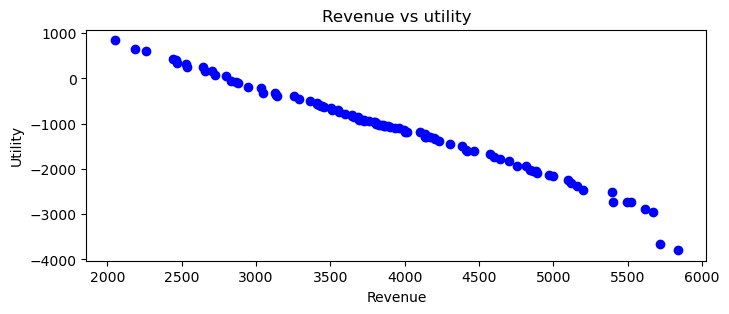

In [25]:
plt.figure(figsize=(8,3))
plt.scatter(X,Y , color="b")
plt.title("Revenue vs utility")
plt.xlabel("Revenue")
plt.ylabel("Utility")
# plt.savefig('EMA_n_5.jpg')
plt.show()

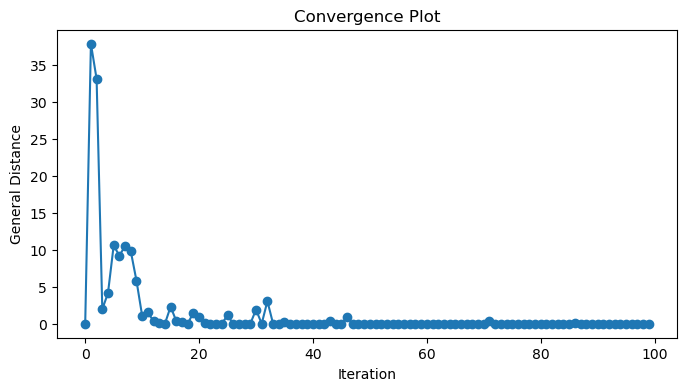

In [26]:

# Plot convergence
t = range(len(distances))
plt.figure(figsize=(8, 4))
plt.plot(t, distances, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("General Distance")
plt.title("Convergence Plot")
plt.show()

In [31]:
particles

[[(array([ 8.59455246, 16.58871835, 20.78528014, 23.91470125, 26.52087968]),
   24.879992586550525),
  (array([13.77881664, 15.37916769, 25.30568613, 19.20313748, 23.16306832]),
   26.10615076155885),
  (array([33.56803843, 17.68957813, 36.88480089,  8.14241452,  1.97144931]),
   47.74260075315206),
  (array([ 1.025898  , 38.29185489, 32.56513429, 11.98044128, 14.88374677]),
   29.830550304641005),
  (array([10.81993833, 38.72083215,  7.26772639,  9.81842323, 31.04170173]),
   36.03357212404892),
  (array([ 5.32284928, 22.29746995, 28.2533393 , 23.79022261, 19.33611886]),
   54.72627166722602),
  (array([ 4.04926115, 42.00520579,  3.30683324, 44.97205863,  4.66664119]),
   48.34290968249483),
  (array([21.07595949, 16.74198243, 27.25254513,  6.51199118, 27.34541278]),
   33.78904455952426),
  (array([31.15502551, 20.16273695, 11.84708488, 22.39205716, 12.80489929]),
   37.36101276031317),
  (array([ 5.97539863, 50.57734232, 10.00493671,  3.70360681, 27.74658826]),
   51.540739573888175

In [27]:
Y = []
N = num_pevgs
for i in range(N):
    Y.append([])
    
for i in range(10):
    part = particles[i][0]
    for j in range(len(part)):
        Y[j].append(part[j])


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (10, 5).

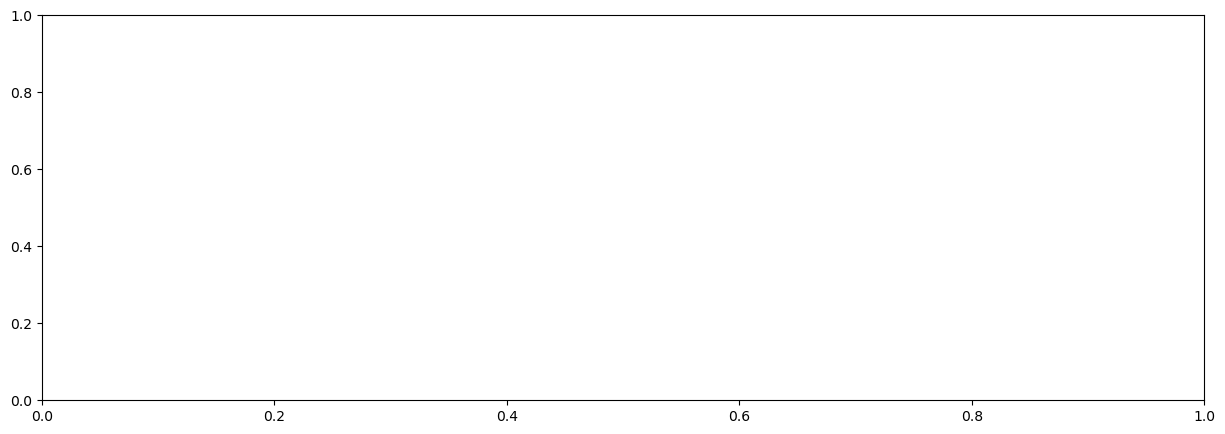

In [28]:
# Colors for different PEVGs
colors = ['b', 'g', 'r', 'c', 'm']
total = 10
x = np.arange(total)
bar_width = 0.15

# Plot bars for each PEVG
plt.figure(figsize=(15, 5))
for i in range(N):
    plt.bar( x + i * bar_width, Y[i], width=bar_width, color=colors[i], label=f'PEVG {i+1}')


# Labels and Title
plt.xlabel('Solution Id')
plt.ylabel('Average Demand (MWh)')
plt.title('Average Demand of PEVGs Over Solution Id')
plt.xticks(x + bar_width * (N ), [f'solution-{i+1}  ' for i in range(total)])  # Adjust X-ticks
plt.legend()
# plt.savefig('EMA_top_10.jpg')
plt.show()

In [32]:
N = 10
C = 99

b_n = [] # Battery capacities (MWh)
s_n = [] # Satisfaction parameters

for i in range(N):
    b_n.append( random.randint(35 , 65) )
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)

In [33]:
pareto_front, particles, distances = ema_algorithm_with_pareto_info(num_pevgs, grid_capacity, battery_capacities, 
                                                                                   satisfaction_parameters, population_size, max_iterations, 
                                                                                   delta, price_lower_bound, price_upper_bound)


In [ ]:
# Run EMA algorithm
# pareto_front , particles = ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound)

In [34]:
X = []
Y = []
for objective in pareto_front:
    X.append(objective[1])
    Y.append(objective[0])


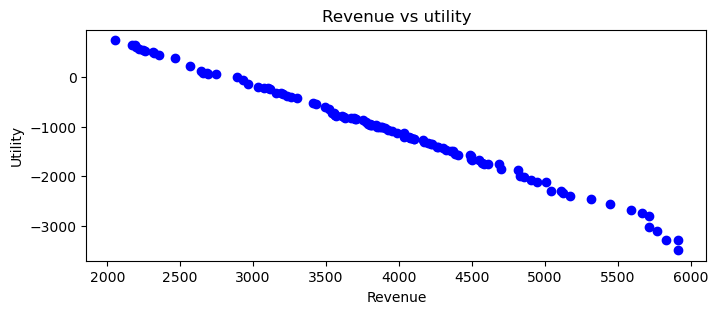

In [35]:
plt.figure(figsize=(8,3))
plt.scatter(X,Y , color="b")
plt.title("Revenue vs utility")
plt.xlabel("Revenue")
plt.ylabel("Utility")
# plt.savefig('EMA_n_5.jpg')
plt.show()

In [ ]:
N = 10
C = 80

b_n = [] # Battery capacities (MWh)
s_n = [] # Satisfaction parameters

for i in range(N):
    b_n.append( random.randint(35 , 65) )
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)

In [ ]:
# Run EMA algorithm
# pareto_front , particles = ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound)

In [ ]:
X = []
Y = []
for objective in pareto_front:
    X.append(objective[1])
    Y.append(objective[0])


In [ ]:
plt.figure(figsize=(8,3))
plt.scatter(X,Y , color="b")
plt.title("Revenue vs utility")
plt.xlabel("Revenue")
plt.ylabel("Utility")
# plt.savefig('EMA_n_5.jpg')
plt.show()